In [38]:
import xarray as xr
import numpy as np
import netCDF4
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'tensorflow'

In [39]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 376.9/376.9 MB 13.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 69.0 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 133.7/133.7 kB ? eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 86.8 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 63.2 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 88.4 MB/s eta 0:00:00
     --------------------------------------- 26.4/26.4 MB 65.5 MB/s eta 0:00:00
     ---------------------------------------- 413.4/413.4 kB ? eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 92.3 MB/s eta 0:00:00
     ---------------------------------------- 127.7/127.7 kB ? eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# load inputs: satellite data
# interpolated_file_path = r'C:\Users\LMS-youranl\Downloads\data\interpolated_data.nc'
input_file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_data/interpolated_data.nc'
ds_input = xr.open_dataset(input_file_path)

In [ ]:
# load outputs:WOA13 data
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
# from sklearn.preprocessing import StandardScaler

# Define the base directory and file patterns
# base_dir = '/content/drive/MyDrive/hakData/'
# base_dir = {'/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/',
#            '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/phosphate/netcdf/all/1.00/',
#            '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/silicate/netcdf/all/1.00/'}

base_dirs = {
    'nitrate': '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/',
    'phosphate': '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/phosphate/netcdf/all/1.00/',
    'silicate': '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/silicate/netcdf/all/1.00/'
}

file_patterns = {
    'nitrate': 'woa13_all_n01_01.nc',
    'phosphate': 'woa13_all_p01_01.nc',
    'silicate': 'woa13_all_i01_01.nc'
}

# Initialize dictionaries to hold the data
lat = None
lon = None
nutrient_data = {}

# Read the data for each nutrient
for nutrient, base_dir in base_dirs.items():
    pattern = file_patterns[nutrient]
    ds = xr.open_dataset(os.path.join(base_dir, pattern), engine='netcdf4', decode_times=False)

    # Extract latitude and longitude (all are the same)
    if lat is None and lon is None:
        lat = ds['lat'].values
        lon = ds['lon'].values

    # Extract surface layer data
    if nutrient == 'nitrate':
        nutrient_data['nitrate'] = ds['n_an'].values[0, 0, :, :]  # Extract surface layer
    elif nutrient == 'phosphate':
        nutrient_data['phosphate'] = ds['p_an'].values[0, 0, :, :]  # Extract surface layer
    elif nutrient == 'silicate':
        nutrient_data['silicate'] = ds['i_an'].values[0, 0, :, :]  # Extract surface layer


# Combine the nutrient data into a single 3x180x360 array
combined_data = np.stack((nutrient_data['nitrate'], nutrient_data['phosphate'], nutrient_data['silicate']), axis=0)

# Transpose combined_data to shape (180, 360, 3) to get (lat, lon, features)
data = combined_data.transpose((1, 2, 0))

# Create an xarray Dataset
ds_output = xr.Dataset(
    {
        'nitrate': (['lat', 'lon'], nutrient_data['nitrate']),
        'phosphate': (['lat', 'lon'], nutrient_data['phosphate']),
        'silicate': (['lat', 'lon'], nutrient_data['silicate'])
    },
    coords={
        'lat': lat,
        'lon': lon
    }
)

In [ ]:
# combine inputs and outputs into one dataset
ds_input_january = ds_input.sel(month=1).drop('month')
ds_combined = xr.merge([ds_input_january, ds_output])

output_file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_and_WOA13_1_degree_Jan.nc'
ds_combined.to_netcdf(output_file_path, format='NETCDF4')

In [4]:
# plot in local jupyternotebook
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm

file_path = r'C:\Users\LMS-youranl\Downloads\data\satellite_and_WOA13_1_degree_Jan.nc'
ds = xr.open_dataset(file_path, engine='netcdf4', decode_times=False)

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    CHL        (lat, lon) float64 ...
    APH        (lat, lon) float64 ...
    FLU        (lat, lon) float64 ...
    PIC        (lat, lon) float64 ...
    POC        (lat, lon) float64 ...
    PAR        (lat, lon) float64 ...
    SST        (lat, lon) float64 ...
    nitrate    (lat, lon) float32 ...
    phosphate  (lat, lon) float32 ...
    silicate   (lat, lon) float32 ...

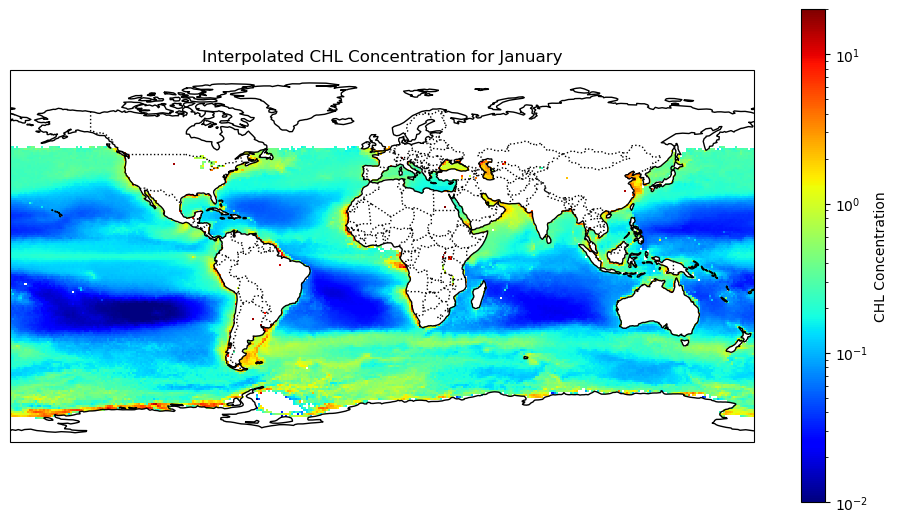

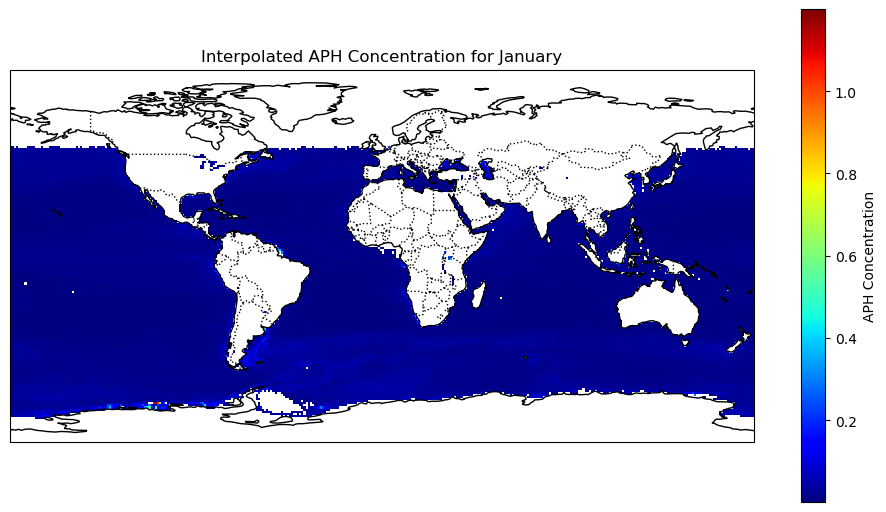

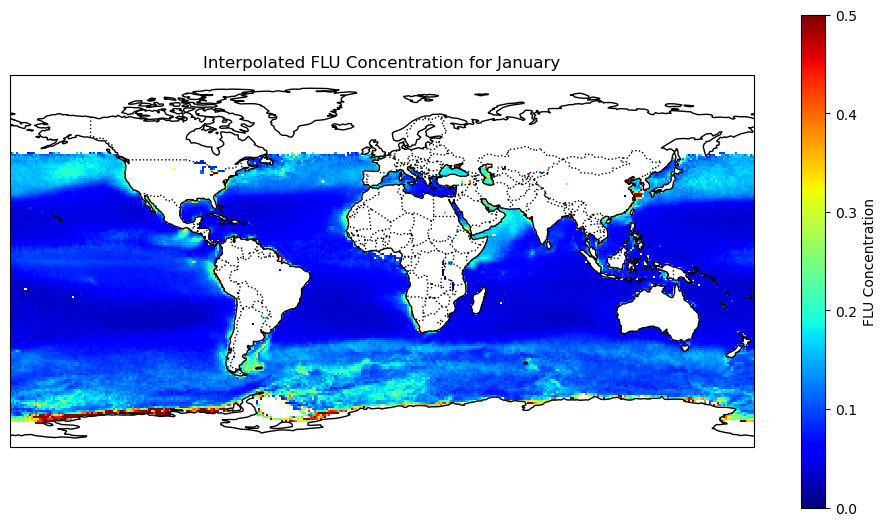

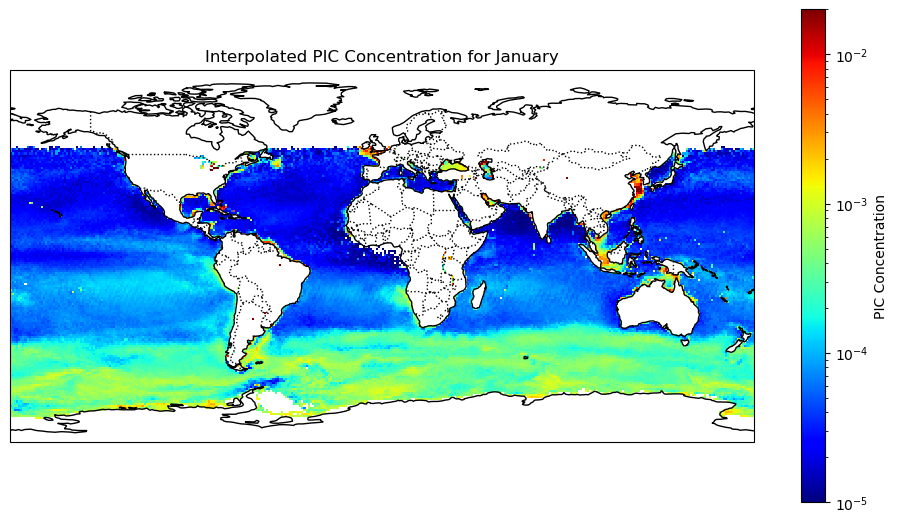

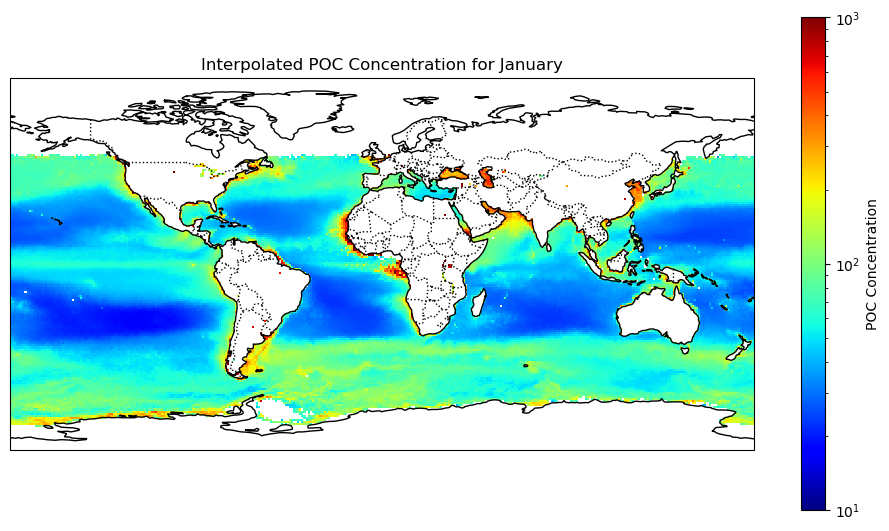

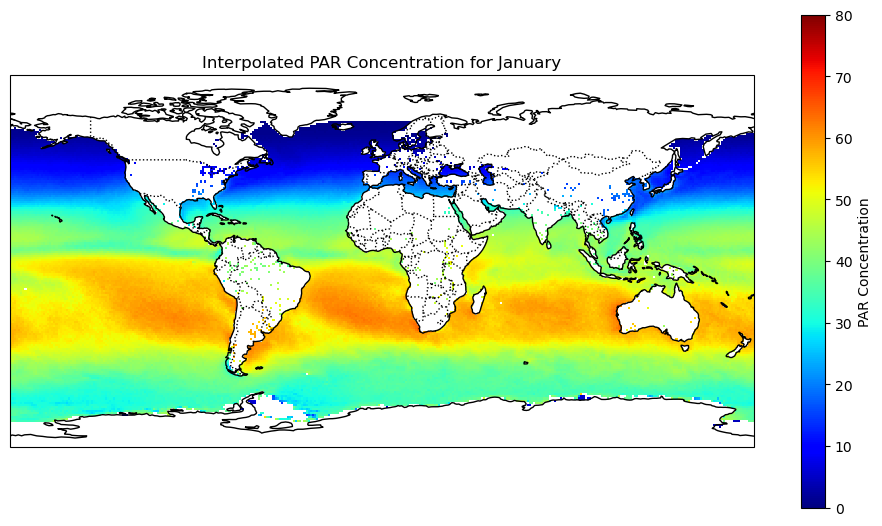

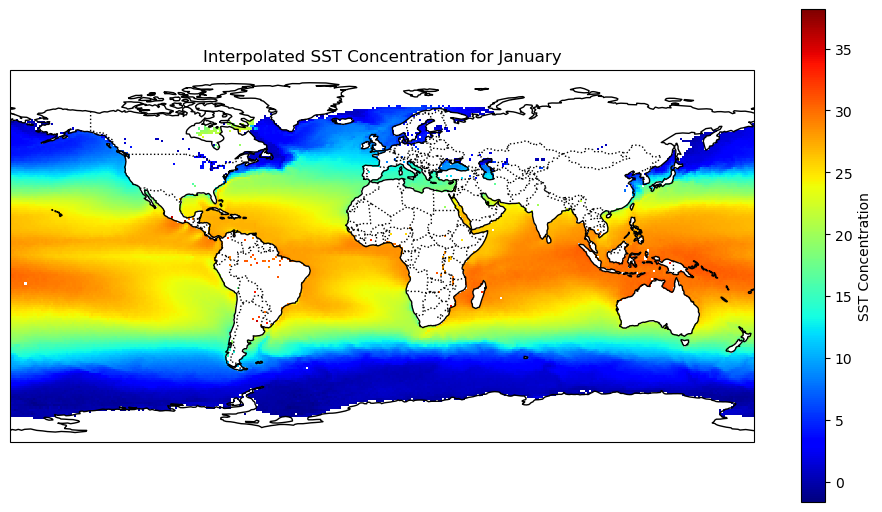

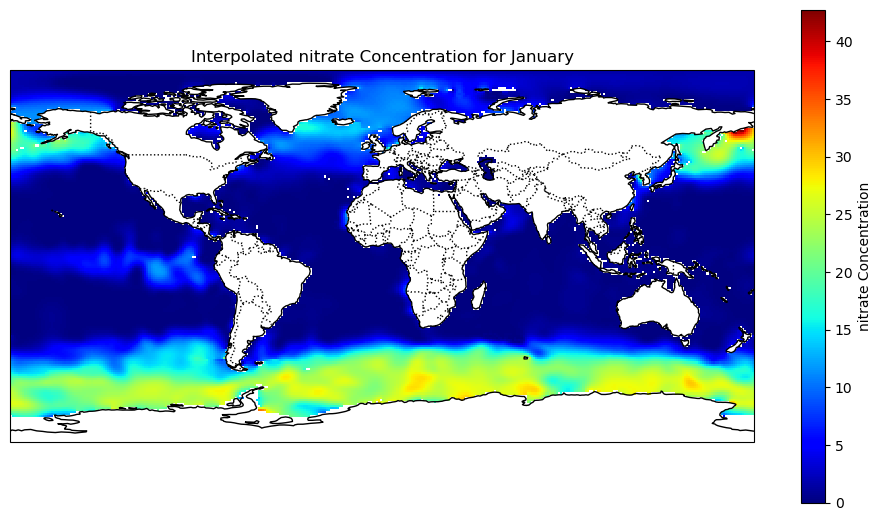

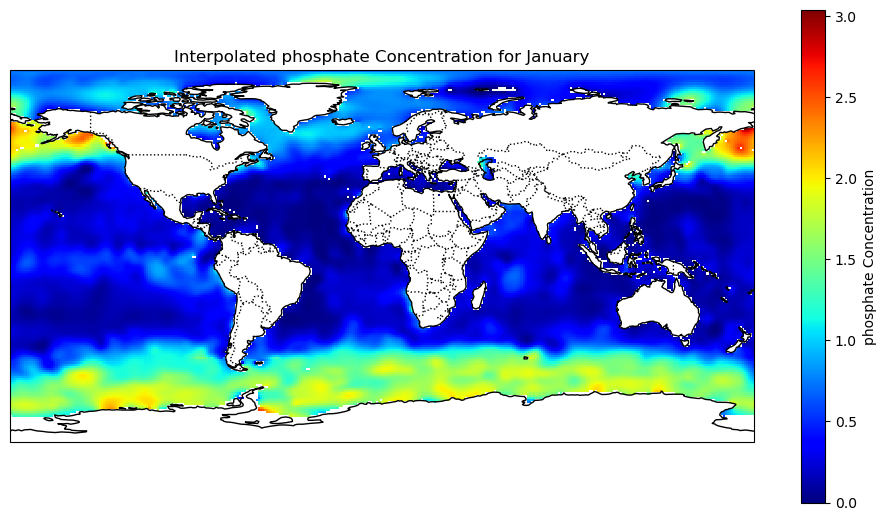

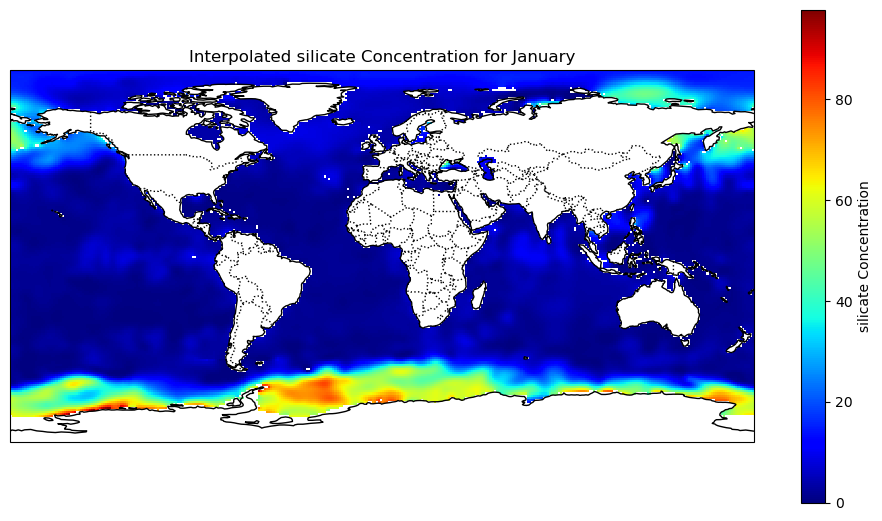

In [5]:
# List of variables to plot
variables = ['CHL', 'APH', 'FLU', 'PIC', 'POC', 'PAR', 'SST', 'nitrate', 'phosphate', 'silicate']

# Plotting each variable
for var in variables:
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data = ds[var]

    # Apply different color scales as needed
    if var == 'CHL':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=0.01, vmax=20))
    elif var == 'FLU':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', vmin=0, vmax=0.5)
    elif var == 'PAR':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', vmin=0, vmax=80)
    elif var == 'PIC':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=1e-5, vmax=0.02))
    elif var == 'POC':
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet', norm=LogNorm(vmin=10, vmax=1000))
    else:
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], data, cmap='jet')

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(f'{var} Concentration')
    ax.set_title(f'Interpolated {var} Concentration for January')
    plt.show()

### filter the dataset to < 1km

In [18]:
# Path to the nitrate data file
# nitrate_file_path = '/expanse/lustre/projects/unc107/yli39/data/WOA13/DATAv2/nitrate/netcdf/all/1.00/woa13_all_n01_01.nc'
# ds = xr.open_dataset(nitrate_file_path, engine='netcdf4', decode_times=False)
# ds
import pandas as pd
# Download and read the bathymetry data
bathymetry_url = "https://neo.gsfc.nasa.gov/servlet/RenderData?si=189313&cs=rgb&format=SS.CSV&width=360&height=180"
bathymetry_df = pd.read_csv(bathymetry_url, header=None)

# Extract longitude and latitude from the CSV
lon = bathymetry_df.iloc[0, 1:].values.astype(float)
lat = bathymetry_df.iloc[1:, 0].values.astype(float)
bathymetry_data = bathymetry_df.iloc[1:, 1:].values.astype(float)

In [21]:
bathymetry_data

array([[-4094.49, -4094.49, -4094.49, ..., -4157.48, -4125.98, -4125.98],
       [-3842.52, -3874.02, -3874.02, ..., -3244.09, -3527.56, -3779.53],
       [-3842.52, -3842.52, -3842.52, ..., -3842.52, -3842.52, -3842.52],
       ...,
       [99999.  , 99999.  , 99999.  , ..., 99999.  , 99999.  , 99999.  ],
       [99999.  , 99999.  , 99999.  , ..., 99999.  , 99999.  , 99999.  ],
       [99999.  , 99999.  , 99999.  , ..., 99999.  , 99999.  , 99999.  ]])

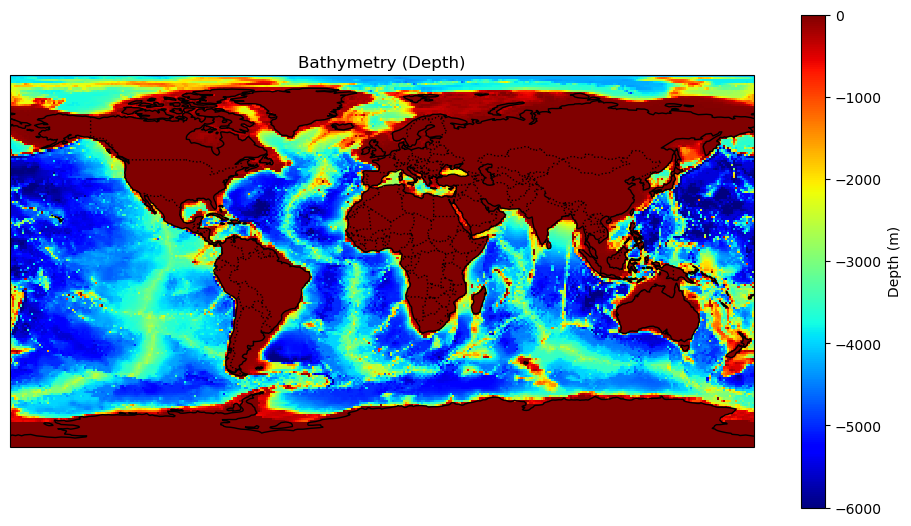

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Plot the depth variable
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
data = bathymetry_data

pcm = ax.pcolormesh(lon, lat, data, cmap='jet', vmin=-6000, vmax=0)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Depth (m)')
ax.set_title('Bathymetry (Depth)')
plt.show()


In [19]:
file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_and_WOA13_1_degree_Jan.nc'
ds = xr.open_dataset(file_path, engine='netcdf4', decode_times=False)
# Add the bathymetry data as a new variable to the dataset
ds['depth'] = (('lat', 'lon'), bathymetry_data)
output_file_path = '/expanse/lustre/projects/unc107/yli39/data/satellite_and_WOA13_1_degree_Jan_v2.nc'
ds.to_netcdf(output_file_path, format='NETCDF4')


In [37]:
ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    CHL        (lat, lon) float64 ...
    APH        (lat, lon) float64 ...
    FLU        (lat, lon) float64 ...
    PIC        (lat, lon) float64 ...
    POC        (lat, lon) float64 ...
    PAR        (lat, lon) float64 ...
    SST        (lat, lon) float64 ...
    nitrate    (lat, lon) float32 ...
    phosphate  (lat, lon) float32 ...
    silicate   (lat, lon) float32 ...
    depth      (lat, lon) float64 -4.094e+03 -4.094e+03 -4.094e+03 ... nan nan

In [34]:
# create a new dataset containing only shallower than 1km

# file_path = r'C:\Users\LMS-youranl\Downloads\data\satellite_and_WOA13_1_degree_Jan_v2.nc'
file_path = r'/expanse/lustre/projects/unc107/yli39/data/satellite_and_WOA13_1_degree_Jan_v2.nc'
ds = xr.open_dataset(file_path, engine='netcdf4', decode_times=False)

ds['depth'] = ds['depth'].where(ds['depth'] <= 0)
depth_mask = ds['depth'] >= -2000
ds_filtered = ds.where(depth_mask, drop=True)



In [ ]:
output_file_path_shallow = '/expanse/lustre/projects/unc107/yli39/data/satellite_and_WOA13_1_degree_Jan_shallowerthan2km.nc'
ds_filtered.to_netcdf(output_file_path_shallow, format='NETCDF4')

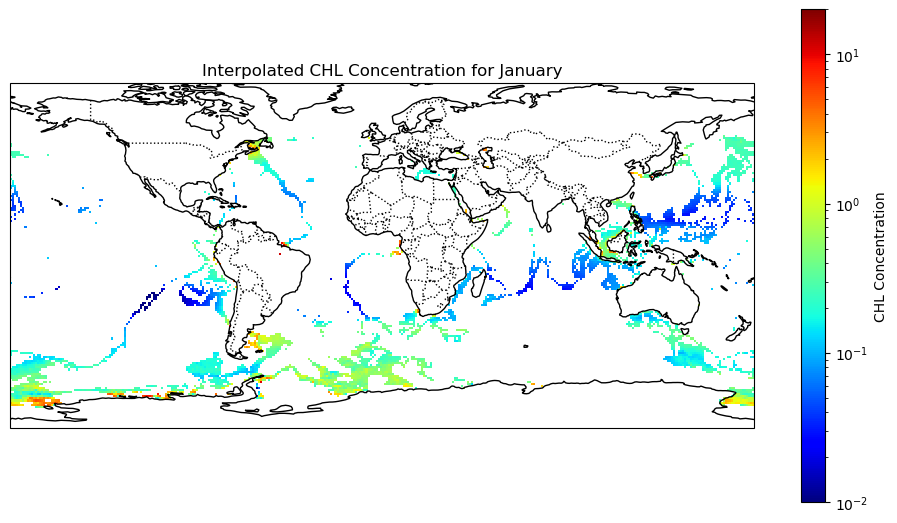

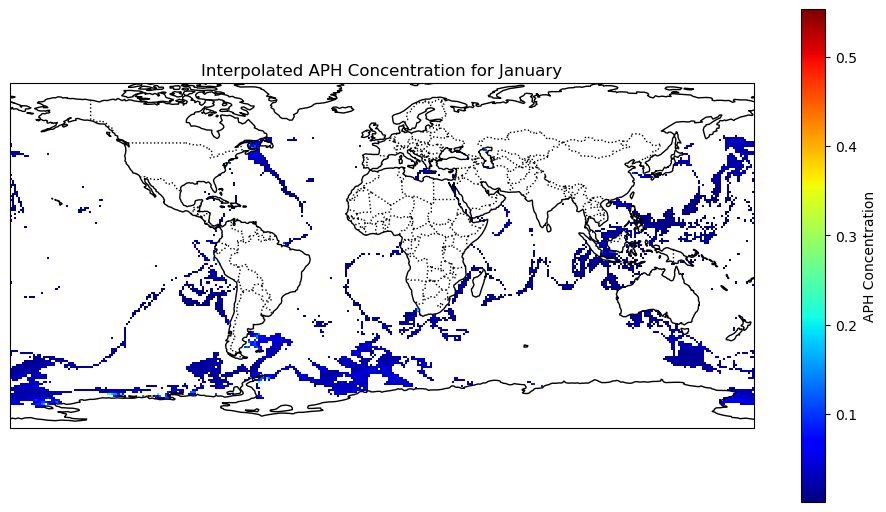

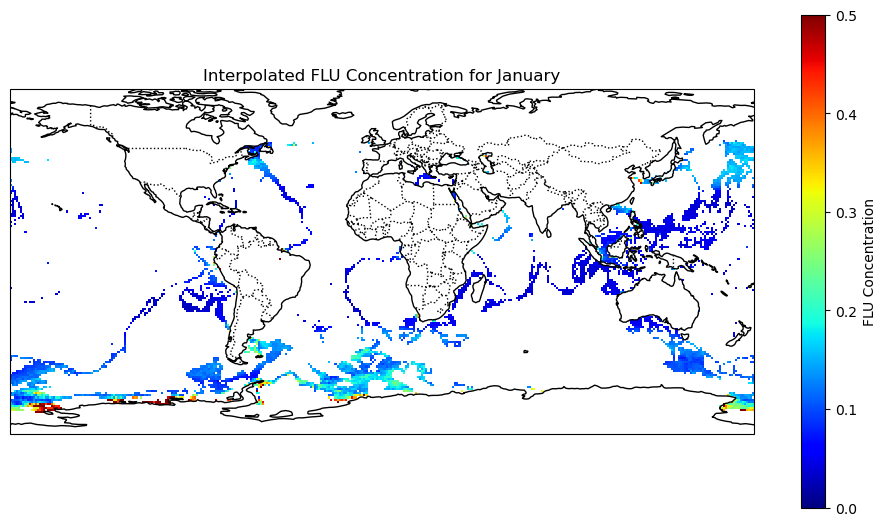

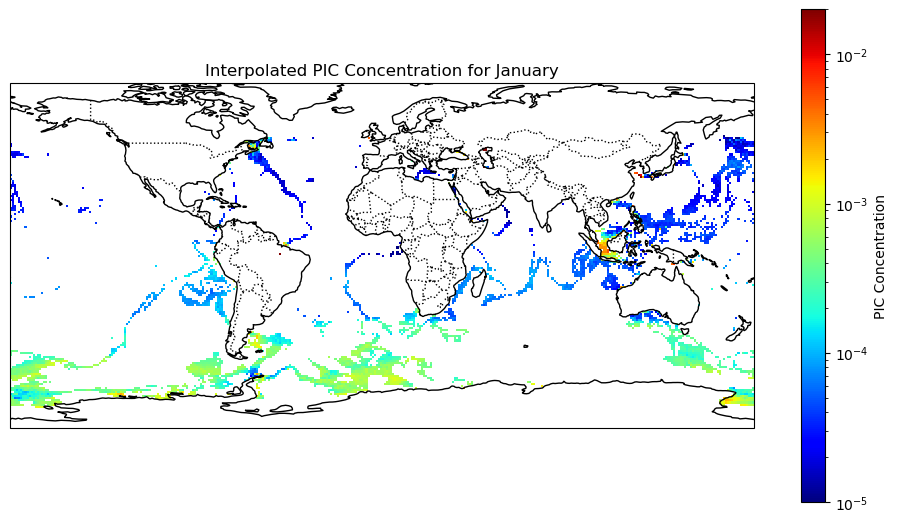

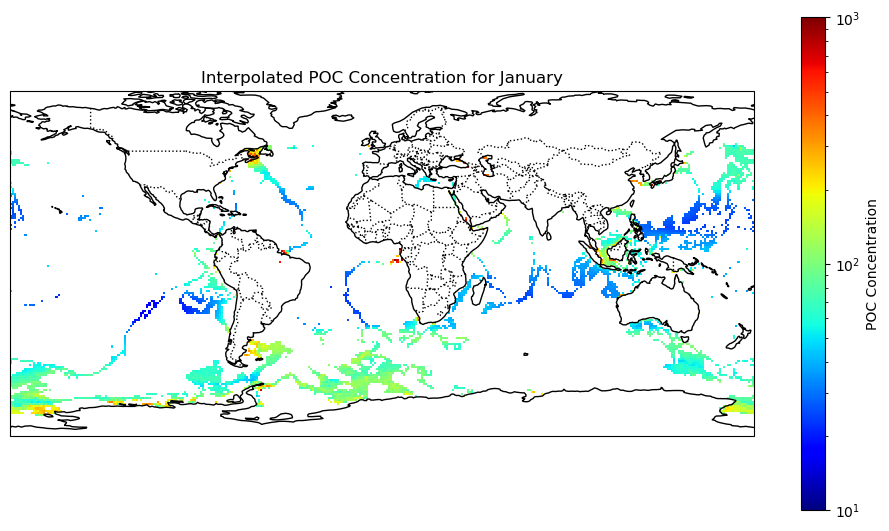

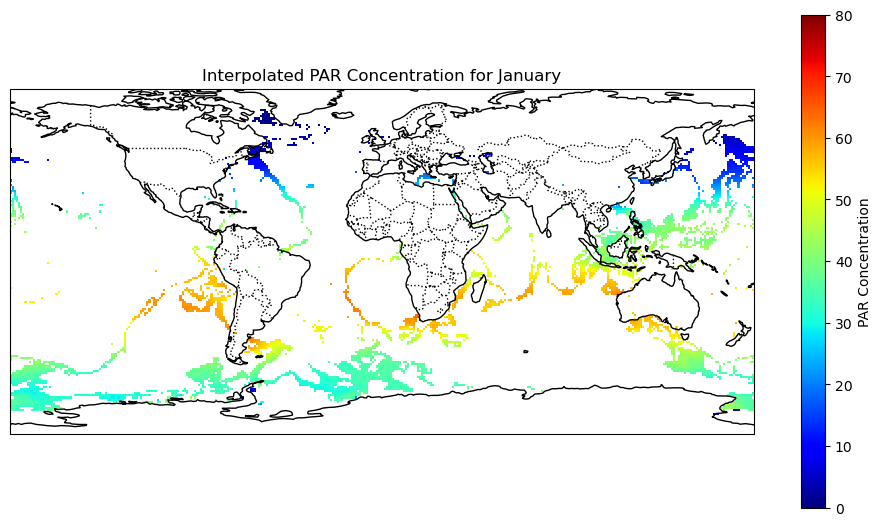

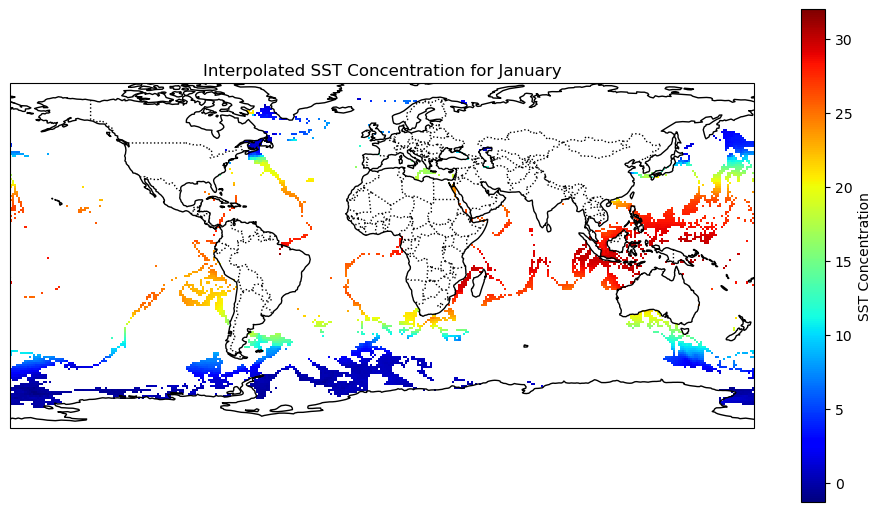

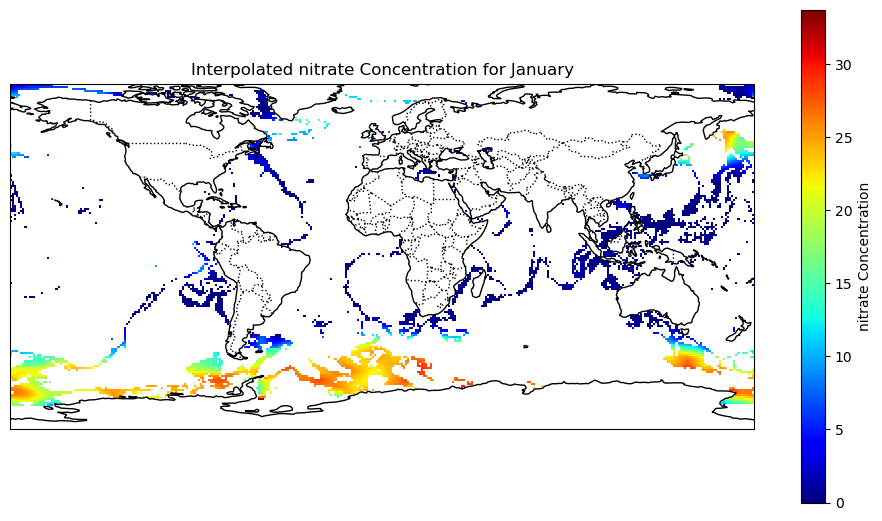

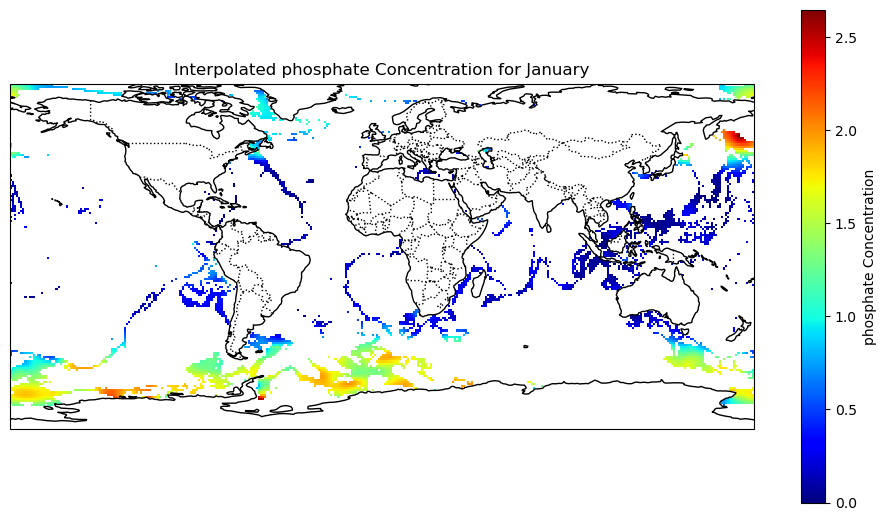

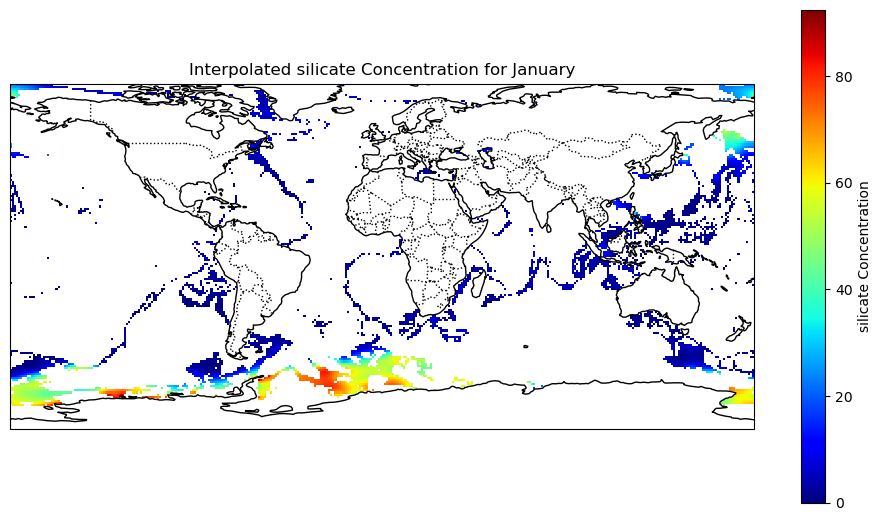

In [36]:
# plot to test
# List of variables to plot
variables = ['CHL', 'APH', 'FLU', 'PIC', 'POC', 'PAR', 'SST', 'nitrate', 'phosphate', 'silicate']
output_dir = r'C:\Users\LMS-youranl\Downloads\data\shallowerthan2km'
# Plotting each variable
for var in variables:
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data = ds_filtered[var]

    # Apply different color scales as needed
    if var == 'CHL':
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet', norm=LogNorm(vmin=0.01, vmax=20))
    elif var == 'FLU':
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet', vmin=0, vmax=0.5)
    elif var == 'PAR':
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet', vmin=0, vmax=80)
    elif var == 'PIC':
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet', norm=LogNorm(vmin=1e-5, vmax=0.02))
    elif var == 'POC':
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet', norm=LogNorm(vmin=10, vmax=1000))
    else:
        pcm = ax.pcolormesh(ds_filtered['lon'], ds_filtered['lat'], data, cmap='jet')

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(f'{var} Concentration')
    ax.set_title(f'Interpolated {var} Concentration for January')
    output_path = os.path.join(output_dir, f'{var}_January.png')
    plt.savefig(output_path, dpi=300)
    plt.show()